<a href="https://colab.research.google.com/github/ast-abo/ShotTracker/blob/Export-Model/ShotTrackerModelTraingScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import sys

drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [ ]:
nb_path = '/content/notebooks'
sys.path.insert(0, nb_path)  # or append(nb_path)
#The last three lines are what changes the path of the file.
!pip install --target=$nb_path


In [2]:
from roboflow import Roboflow
import os
import ultralytics
HOME = os.getcwd()
print(HOME)
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.1/107.7 GB disk)


In [3]:
import os
import shutil

!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg' save=True

# Define paths
OutputDirectory = "runs/detect/predict"
OldFileName = "9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg"  # The original file name
NewFileName = "ball.jpg"  # The desired new name

# Rename the file
OldFilePath = os.path.join(OutputDirectory, OldFileName)
NewFilePath = os.path.join(OutputDirectory, NewFileName)
print(OldFilePath)


try:
    shutil.move(OldFilePath, NewFilePath)
    print(f"File renamed to {NewFilePath}")
except Exception as e:
    print(f"Error renaming file: {e}")

/bin/bash: line 1: yolo: command not found
runs/detect/predict/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg
Error renaming file: [Errno 2] No such file or directory: 'runs/detect/predict/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg'


In [4]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]

100%|██████████| 5.35M/5.35M [00:00<00:00, 139MB/s]



0: 640x448 1 person, 1 clock, 346.4ms
Speed: 27.4ms preprocess, 346.4ms inference, 31.8ms postprocess per image at shape (1, 3, 640, 448)


In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key="NLWnQPigGaE8pl98gFYh")
project = rf.workspace("icespace").project("shot-tracker-ik6bf")
version = project.version(2)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Shot-Tracker-2 in yolov11:: 100%|██████████| 52/52 [00:00<00:00, 5318.18it/s]


In [6]:
%cd {HOME}

results = model.train(data="/content/datasets/Shot-Tracker-2/data.yaml", epochs=100, imgsz=640, optimizer='adam', patience=10)

/content
New https://pypi.org/project/ultralytics/8.3.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/Shot-Tracker-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

100%|██████████| 755k/755k [00:00<00:00, 40.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/Shot-Tracker-2/train/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 1754.25it/s]

train: New cache created: /content/datasets/Shot-Tracker-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/datasets/Shot-Tracker-2/valid/labels... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<00:00, 5482.75it/s]

val: New cache created: /content/datasets/Shot-Tracker-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Argument(s) 'quality_lower' are not valid for transform ImageCompression
       1/10         0G      2.551      5.637      2.497          2        640: 100%|██████████| 2/2 [00:20<00:00, 10.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all          1          1    0.00333          1     0.0131    0.00262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.909      4.805      1.922          2        640: 100%|██████████| 2/2 [00:16<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all          1          1    0.00333          1     0.0553     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       1.75      4.651       1.99          2        640: 100%|██████████| 2/2 [00:16<00:00,  8.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all          1          1    0.00333          1     0.0293    0.00974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.874        4.5      1.958          2        640: 100%|██████████| 2/2 [00:17<00:00,  8.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          1          1    0.00333          1    0.00721    0.00433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.949      4.572      1.967          2        640: 100%|██████████| 2/2 [00:16<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all          1          1    0.00333          1    0.00618    0.00247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.842      4.462      1.659          2        640: 100%|██████████| 2/2 [00:16<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all          1          1    0.00333          1    0.00686    0.00412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.675      4.537       1.76          2        640: 100%|██████████| 2/2 [00:16<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          1          1    0.00333          1    0.00957    0.00478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.162      4.094       1.53          2        640: 100%|██████████| 2/2 [00:17<00:00,  8.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all          1          1    0.00333          1     0.0093    0.00558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.9996      3.714       1.45          2        640: 100%|██████████| 2/2 [00:16<00:00,  8.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all          1          1    0.00333          1     0.0188    0.00695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G       1.65      4.268      1.649          2        640: 100%|██████████| 2/2 [00:16<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all          1          1    0.00333          1     0.0231     0.0079



10 epochs completed in 0.053 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


                   all          1          1    0.00333          1     0.0553     0.0166
Speed: 2.5ms preprocess, 238.6ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/train


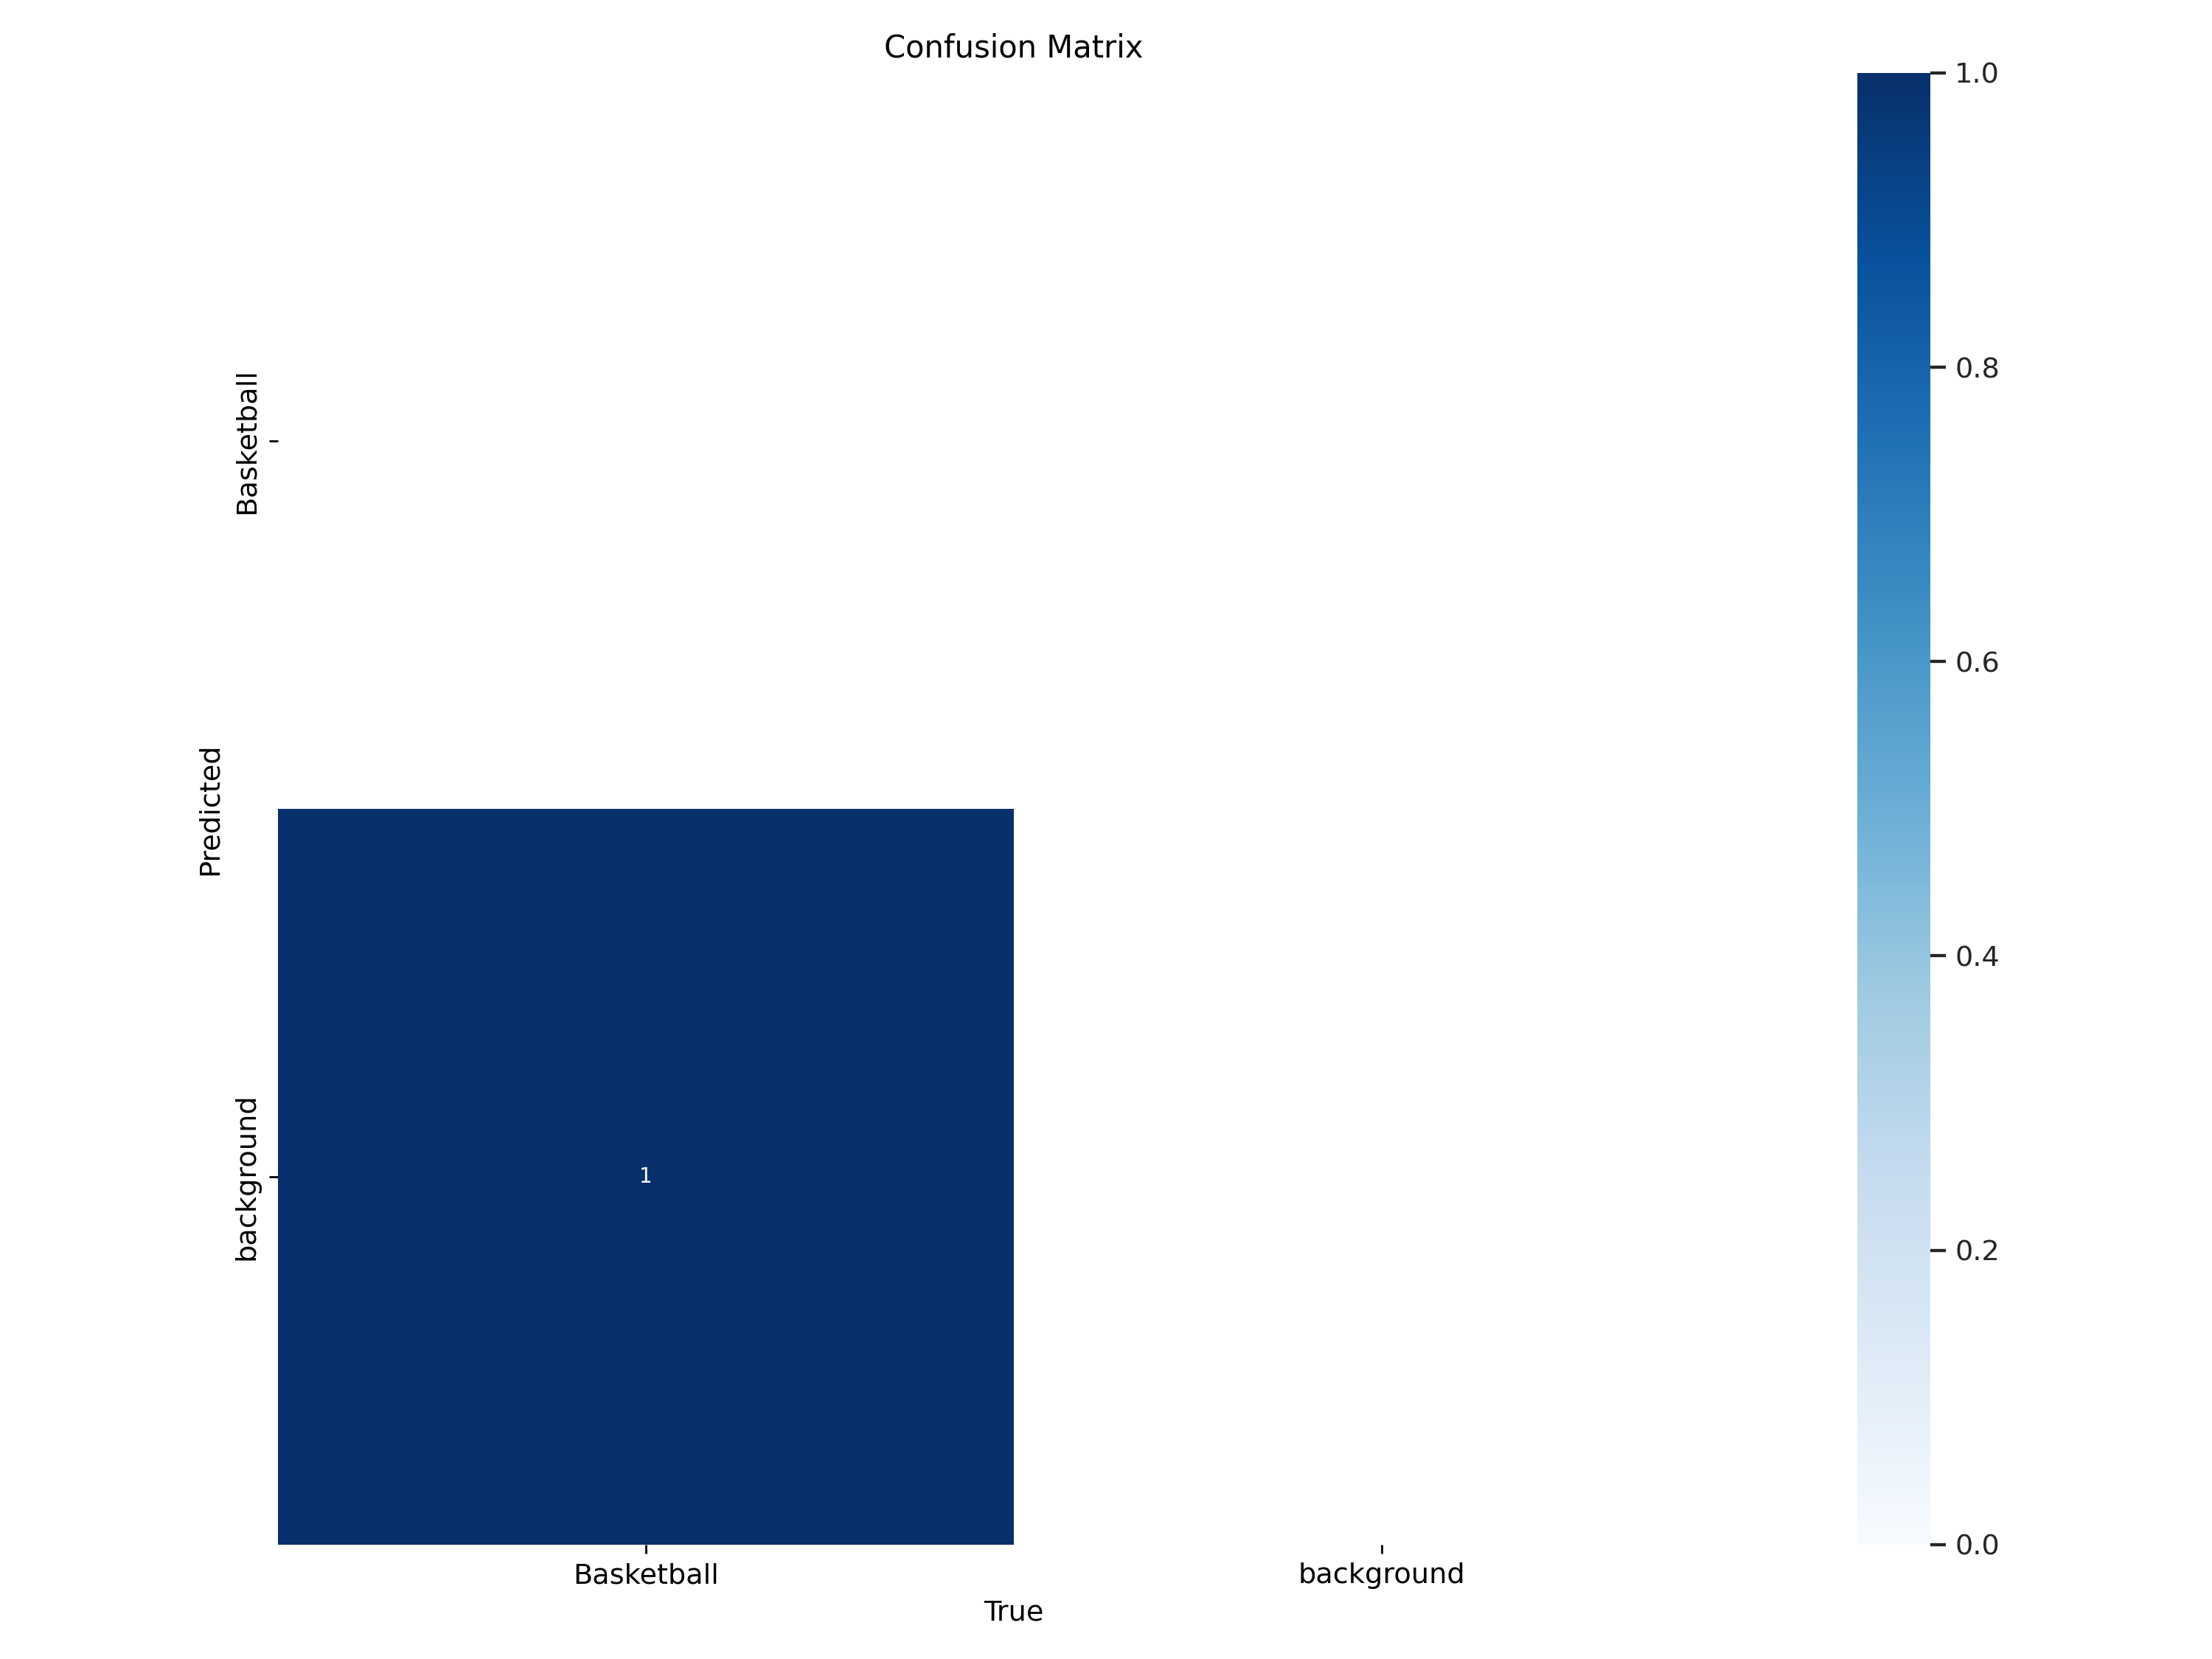

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

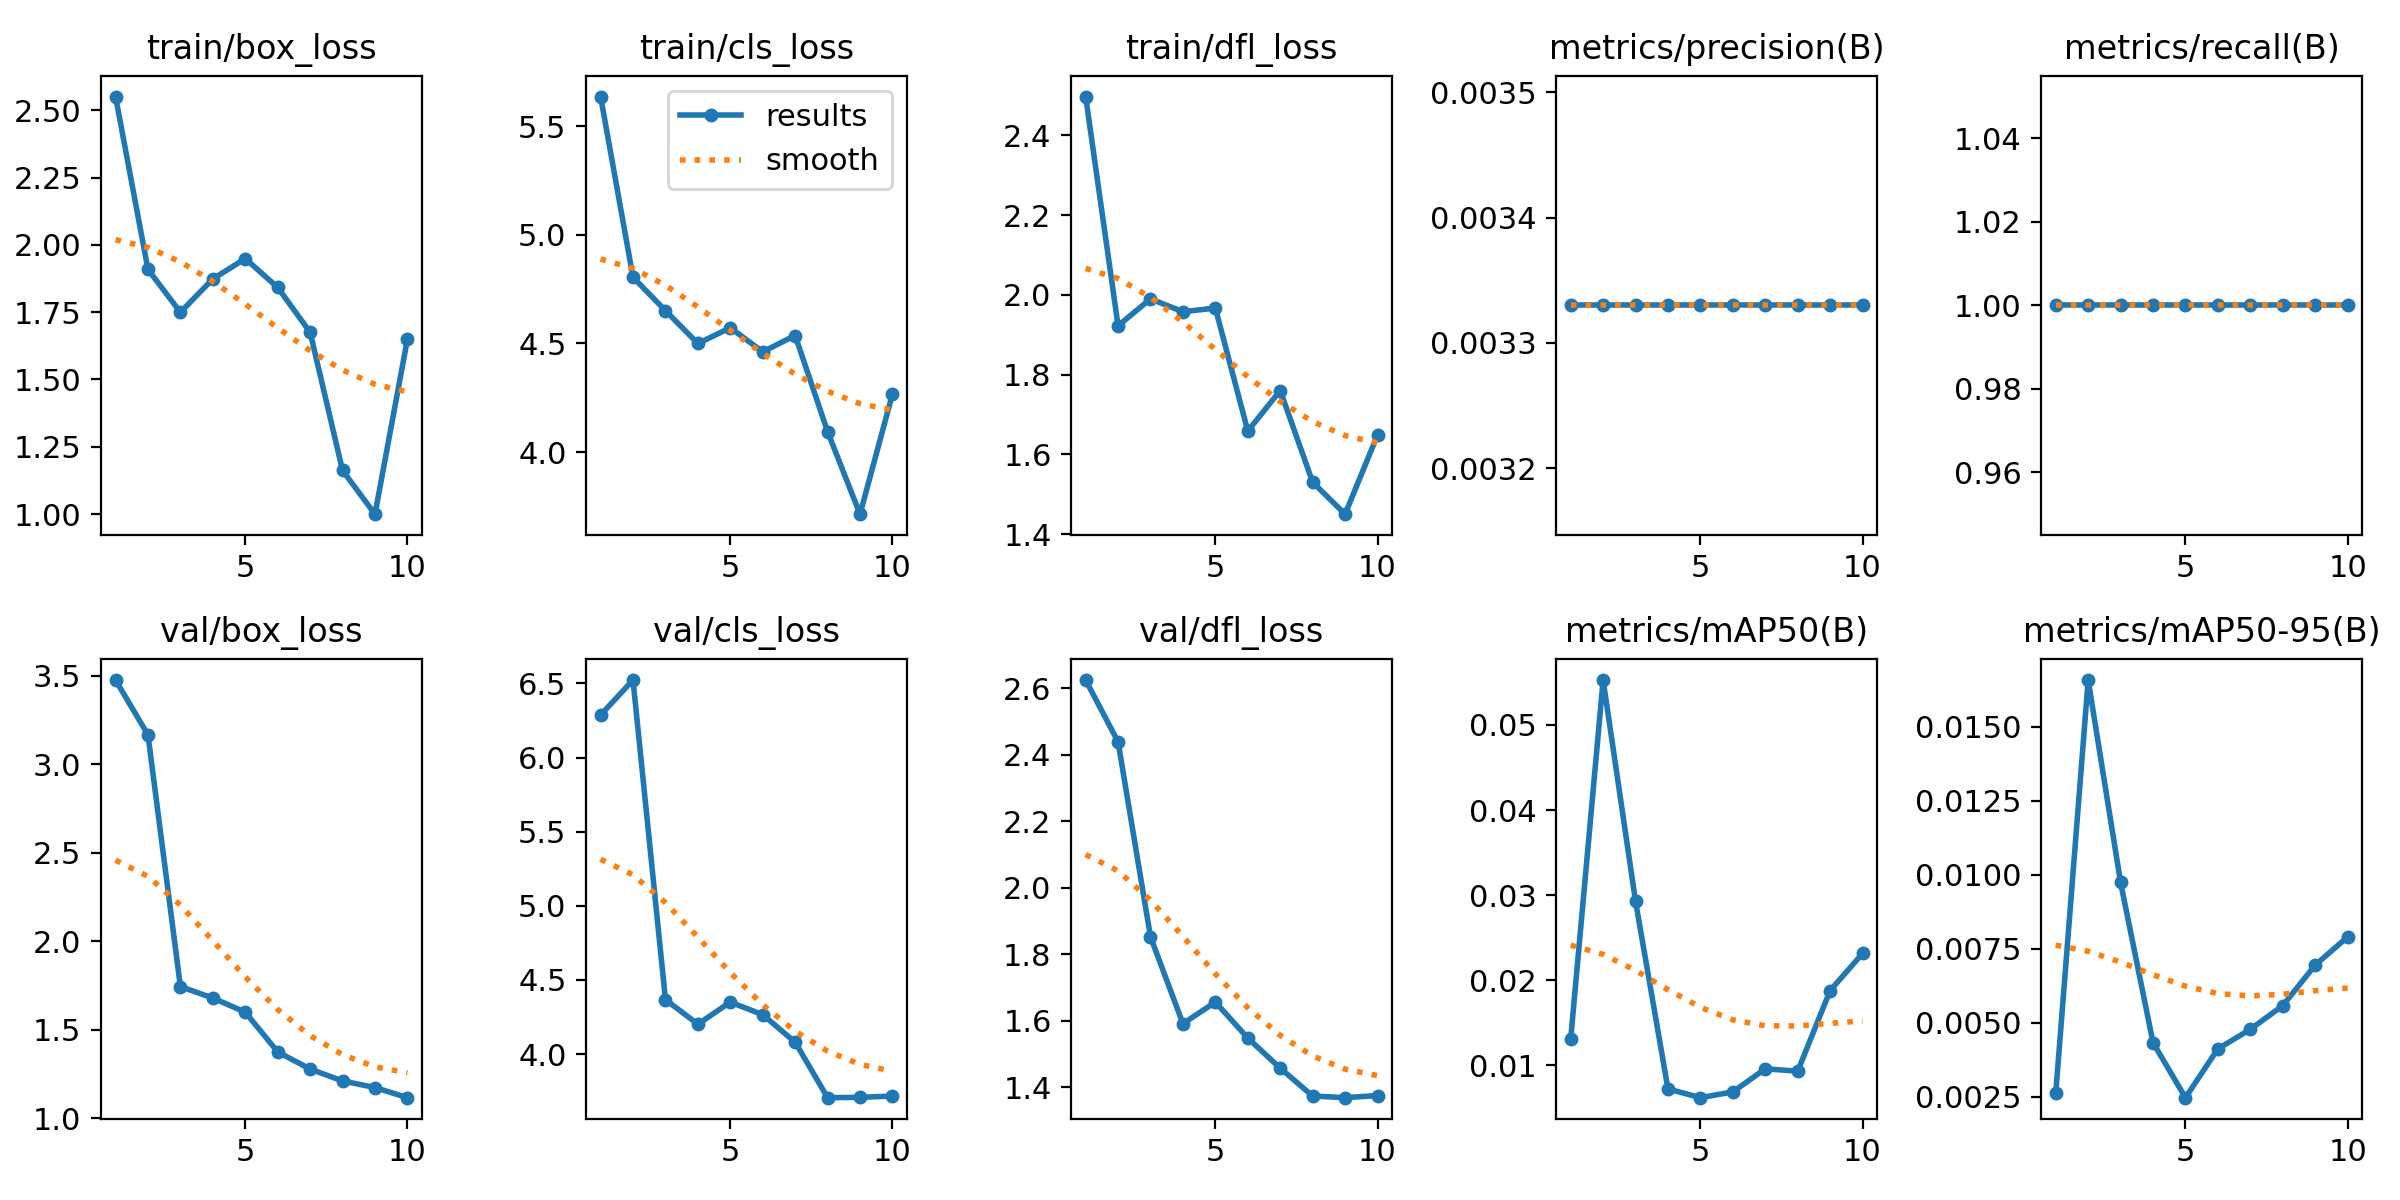

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

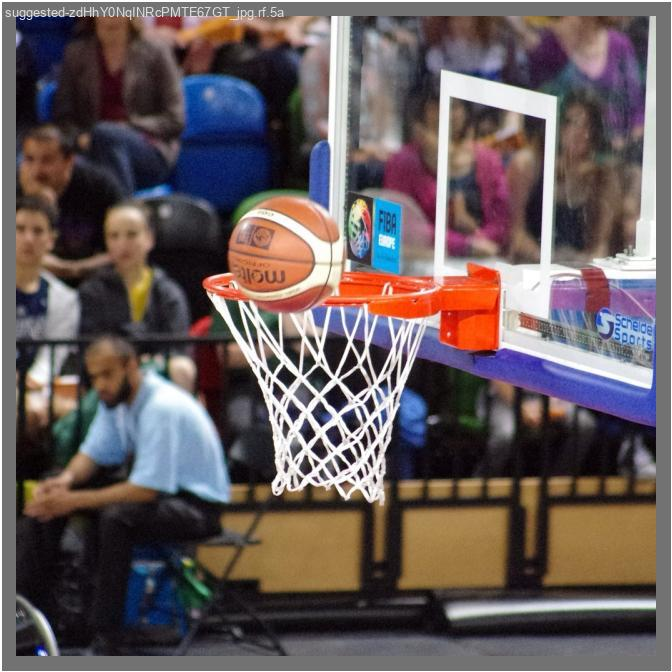

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [11]:
# !yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

In [12]:
# project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

Running inference on suggested-XWTvfDY1tLS473huZiKG_jpg.rf.e6aa4bff9f99c3b197c11a6d7d165961.jpg

0: 640x640 4 persons, 2 ties, 1 vase, 249.5ms
Speed: 5.4ms preprocess, 249.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


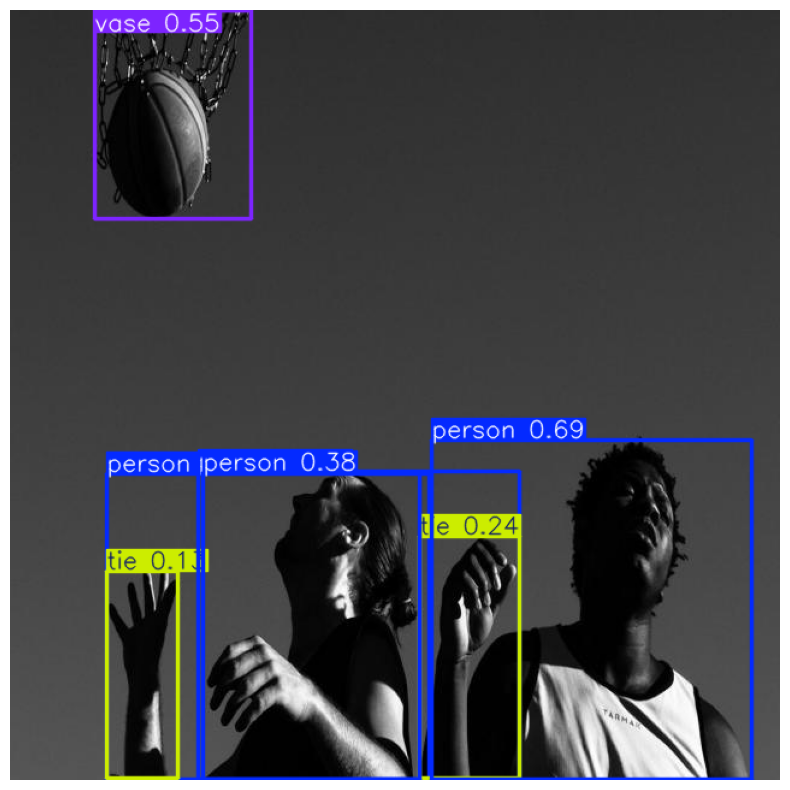

In [16]:
import os, random, cv2
import supervision as sv
import IPython
import matplotlib.pyplot as plt

# Location of test set images
test_set_loc = '/content/datasets/Shot-Tracker-2/test/images'
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))
    if image is None:
      continue

    print("Running inference on " + img_name)

    # Perform inference
    results = model.predict(image, conf=0.1)
    annotatedImage = results[0].plot()

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotatedImage, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis("off")  # Hide axis for better visualization
    plt.show()

In [14]:
# Load the YOLO11 model

# Export the model to TFLite format
model.export(format="torchscript")

# Load the exported TFLite model
# tflite_model = YOLO("yolo11n_float32.tflite")

# Run inference
# results = tflite_model("https://ultralytics.com/images/bus.jpg")

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 3.1s, saved as 'runs/detect/train/weights/best.torchscript' (10.4 MB)

Export complete (3.8s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 data=/content/datasets/Shot-Tracker-2/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'